In [1]:
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree, ensemble, svm

# IPython
from IPython.display import Audio, display

# keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, InputLayer, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.optimizers import RMSprop

%load_ext autoreload
%autoreload 2

from utils import *
from dataset_loader import DatasetLoader
from plot_confusion_matrix import plot_confusion_matrix



/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


# Spectral features

In [2]:
FEATURES_DIR = "../features/mfcc_zcr_fs_44100_window_4096_hop_512/"
META_FILE = '../meta/esc50.csv'
DATASET_DIR = '../audio/'

### Load dataset

In [3]:
dataset_loader = DatasetLoader(FEATURES_DIR, META_FILE, test_fold = 1, category_idx=0)
dataset_loader.load()
# normalize data
# dataset_loader.normalize()

Time taken to load = 0.35


### Visualize features

In [4]:
def play_audio(dataset_loader, idx):
    row = dataset_loader.df_train.iloc[idx]    
    category = row.category
    filename = row.filename
    print(category, filename)
    display(Audio(os.path.join(DATASET_DIR, filename)))


In [9]:
def plot_features(ax, dataset_loader, idx):
    row = dataset_loader.df_train.iloc[idx]
    feat = row.feat
    category = row.category
    filename = row.filename

    # convert hop size to time
    hop_to_time = np.arange(feat.shape[1]) * 256.0 / 22050.0
    hop_to_time = hop_to_time.round(decimals=2)
    # plot
    p = ax.imshow(feat, aspect='auto')
    ax.set_title(category)
    ax.set_xlabel('time')
    plt.colorbar(p, ax=ax)


In [10]:
play_audio(dataset_loader, 21)

dog 2-116400-A-0.wav


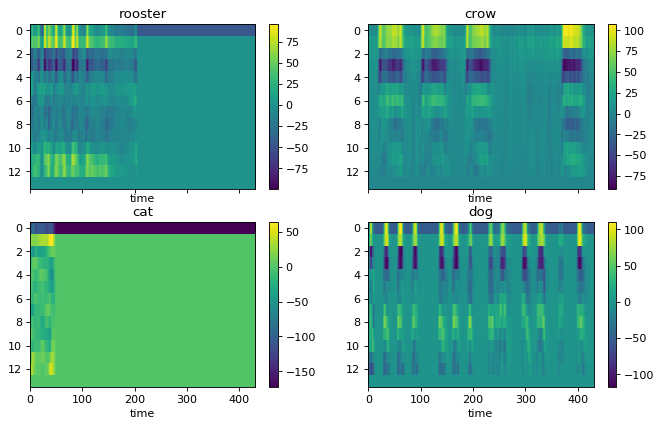

In [35]:
fig, ax = plt.subplots(2,2, figsize=(10,6), sharex=True, dpi=80)
plot_features(ax[0,0], dataset_loader, 0)
plot_features(ax[0,1], dataset_loader, 8)
plot_features(ax[1,0], dataset_loader, 15)
plot_features(ax[1,1], dataset_loader, 20)

In [16]:
X_train, y_train = dataset_loader.get_train_data()
X_test, y_test = dataset_loader.get_test_data()

### Method  1
Mean and std


In [17]:
X_train = np.concatenate([X_train.mean(axis=2), X_train.std(axis=2)], axis=1)
X_test = np.concatenate([X_test.mean(axis=2), X_test.std(axis=2)], axis=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 28), (320,), (80, 28), (80,))

### Random forest

In [21]:
clf = ensemble.RandomForestClassifier(n_estimators=500, max_depth=25)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.6)

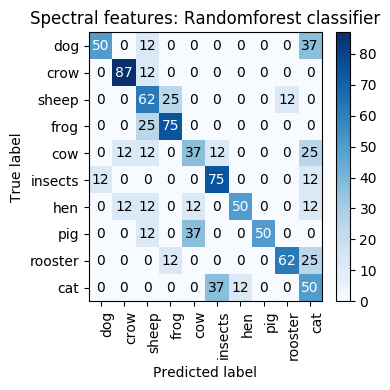

In [22]:
y_test_pred = clf.predict(X_test)

plot_confusion_matrix(y_true=y_test, y_pred=y_test_pred, normalize=True, figsize=(4,4),
                      classes=dataset_loader.classes, title='Spectral features: Randomforest classifier')

### MLP

In [33]:
# keras training settings
batch_size = 32
num_classes = 50
epochs = 80

# mlp
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               3712      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                6450      
Total para

In [34]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

history = model.fit(X_train, y_train_cat,
                batch_size=batch_size,
                epochs=epochs,
                verbose=2,
                validation_data=(X_test, y_test_cat))

Train on 320 samples, validate on 80 samples
Epoch 1/80
 - 1s - loss: 13.6521 - acc: 0.0375 - val_loss: 9.0600 - val_acc: 0.0500
Epoch 2/80
 - 0s - loss: 11.5299 - acc: 0.0781 - val_loss: 7.3036 - val_acc: 0.1750
Epoch 3/80
 - 0s - loss: 10.1673 - acc: 0.1000 - val_loss: 5.4951 - val_acc: 0.2625
Epoch 4/80
 - 0s - loss: 8.6163 - acc: 0.1375 - val_loss: 4.1641 - val_acc: 0.3375
Epoch 5/80
 - 0s - loss: 7.5455 - acc: 0.1219 - val_loss: 3.0778 - val_acc: 0.3125
Epoch 6/80
 - 0s - loss: 5.3865 - acc: 0.1750 - val_loss: 2.5581 - val_acc: 0.4000
Epoch 7/80
 - 0s - loss: 4.9409 - acc: 0.1500 - val_loss: 2.5679 - val_acc: 0.3125
Epoch 8/80
 - 0s - loss: 4.2948 - acc: 0.1562 - val_loss: 2.7681 - val_acc: 0.3500
Epoch 9/80
 - 0s - loss: 3.5694 - acc: 0.1594 - val_loss: 2.8177 - val_acc: 0.3500
Epoch 10/80
 - 0s - loss: 3.2914 - acc: 0.1781 - val_loss: 2.5681 - val_acc: 0.3250
Epoch 11/80
 - 0s - loss: 3.1652 - acc: 0.2094 - val_loss: 2.5824 - val_acc: 0.3375
Epoch 12/80
 - 0s - loss: 3.0805 - ac

### Method 2
CNN 

In [45]:
X_train, y_train = dataset_loader.get_train_data()
X_test, y_test = dataset_loader.get_test_data()

In [46]:
# add extra channel for cnn input
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train.shape, X_test.shape

((320, 14, 431, 1), (80, 14, 431, 1))

In [48]:
# keras training settings
batch_size = 32
num_classes = 50
epochs = 80

# Keras model
model = Sequential()
model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 4)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 4)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 4)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 14, 431, 1)        4         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 431, 32)       320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 431, 32)       9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 107, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 107, 128)       36992     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 107, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 26, 128)        0         
__________

In [49]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

history = model.fit(X_train, y_train_cat,
                batch_size=batch_size,
                epochs=epochs,
                verbose=2,
                validation_data=(X_test, y_test_cat))

Train on 320 samples, validate on 80 samples
Epoch 1/80
 - 7s - loss: 3.7508 - acc: 0.0656 - val_loss: 3.2845 - val_acc: 0.1000
Epoch 2/80
 - 6s - loss: 3.3064 - acc: 0.0938 - val_loss: 2.8763 - val_acc: 0.1000
Epoch 3/80
 - 6s - loss: 2.9494 - acc: 0.0938 - val_loss: 2.4490 - val_acc: 0.1625
Epoch 4/80
 - 6s - loss: 2.6425 - acc: 0.1156 - val_loss: 2.5565 - val_acc: 0.2250
Epoch 5/80
 - 6s - loss: 2.5567 - acc: 0.1187 - val_loss: 2.3414 - val_acc: 0.1500
Epoch 6/80
 - 6s - loss: 2.5395 - acc: 0.1125 - val_loss: 2.4506 - val_acc: 0.1750
Epoch 7/80
 - 6s - loss: 2.4109 - acc: 0.1719 - val_loss: 2.2304 - val_acc: 0.1875
Epoch 8/80
 - 6s - loss: 2.4056 - acc: 0.1594 - val_loss: 2.2839 - val_acc: 0.1625
Epoch 9/80
 - 6s - loss: 2.4409 - acc: 0.1750 - val_loss: 2.0431 - val_acc: 0.3125
Epoch 10/80
 - 6s - loss: 2.2278 - acc: 0.2125 - val_loss: 2.1006 - val_acc: 0.2500
Epoch 11/80
 - 6s - loss: 2.1183 - acc: 0.2594 - val_loss: 1.9392 - val_acc: 0.2875
Epoch 12/80
 - 6s - loss: 2.0417 - acc: 